# Student Depression Prediction Project

**Author:** *Carissa Mason*  
**Dataset:** [Kaggle – Student Depression Dataset](https://www.kaggle.com/datasets/adilshamim8/student-depression-dataset)

---

### Project Overview
This project explores whether we can predict student depression using a variety of personal and academic features. Using logistic regression, the goal was to build a predictive model that balances accuracy with interpretability and could hypothetically support early intervention efforts in identifying students at risk for depression.

---

### Key Steps
- Cleaned and encoded categorical and ordinal data
- Dropped rows with missing or invalid values
- Visualized correlations to guide feature selection
- Selected the following 8 features based on correlation, their relevance to student mental health, and model testing:
  - `Gender`
  - `Age`
  - `Academic Pressure`
  - `Have you ever had suicidal thoughts ?`
  - `Work/Study Hours`
  - `Financial Stress`
  - `Work Pressure`

---

### Model Summary
- **Model Used:** Logistic Regression
- **Penalty:** L2 Regularization (Ridge)
- **Best Parameters (via GridSearchCV):** `penalty='l2'`, `C=0.1`, `solver='liblinear'`
- **Test Accuracy:** ~84%

---

### Ethical Considerations
- Mental health data is sensitive. This model should never replace professional care.
- Predictions should be used as supporting tools, not final decisions.
- Data privacy, consent, and ethical application are critical when working with student mental health indicators.

---

### Requirements
To run this project, install the following packages (included in `requirements.txt`):

```txt
pandas==2.2.2
numpy==1.26.4
matplotlib==3.8.4
seaborn==0.13.2
scikit-learn==1.4.2
notebook==7.1.2     # Jupyter notebooks

In [2]:
# Common imports
import numpy as np
import pandas as pd

In [3]:
# Load and view data
data_path = "data/student_depression_dataset.csv"
df = pd.read_csv(data_path)
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [4]:
# Check for missing/null values
missing_values = df.isnull().sum()

# Display results
missing_values

id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [5]:
# Check data types
df.dtypes

id                                         int64
Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                          object
Family History of Mental Illness          object
Depression                                 int64
dtype: object

In [6]:
from sklearn.preprocessing import LabelEncoder

# Dropped the ID & Job Satisfaction columns, irrelevant to the model
df_cleaned = df.drop(columns=['id', 'Job Satisfaction'])

# Stripped extra whitespace and removed apostrophes from string/object columns
for col in df_cleaned.select_dtypes(include='object').columns:
    df_cleaned[col] = df_cleaned[col].astype(str).str.strip().str.replace("'", "")

# Label encoded binary categorical columns (Yes/No, Male/Female)
label_cols = ['Gender',
              'Have you ever had suicidal thoughts ?',
              'Family History of Mental Illness']

le = LabelEncoder()
for col in label_cols:
    df_cleaned[col] = le.fit_transform(df_cleaned[col])

# Ordinal encoded Sleep Duration
sleep_map = {
    'Less than 5 hours': 1,
    '5-6 hours': 2,
    '7-8 hours': 3,
    'More than 8 hours': 4
}
df_cleaned['Sleep Duration Ordinal'] = df_cleaned['Sleep Duration'].map(sleep_map)

# Converted 'Financial Stress' to numeric
df_cleaned['Financial Stress'] = pd.to_numeric(df_cleaned['Financial Stress'], errors='coerce')

# Dropped rows with missing values in the 'Financial Stress' or 'Sleep Duration Ordinal'
df_cleaned = df_cleaned.dropna(subset=['Financial Stress', 'Sleep Duration Ordinal'])

# One-hot encoded remaining multi-category features
df_encoded = pd.get_dummies(df_cleaned, columns=['City', 'Profession', 'Dietary Habits', 'Degree'], drop_first=True)

# Displayed the cleaned and encoded dataset structure
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
Index: 27880 entries, 0 to 27900
Columns: 107 entries, Gender to Degree_PhD
dtypes: bool(94), float64(8), int32(3), int64(1), object(1)
memory usage: 5.2+ MB


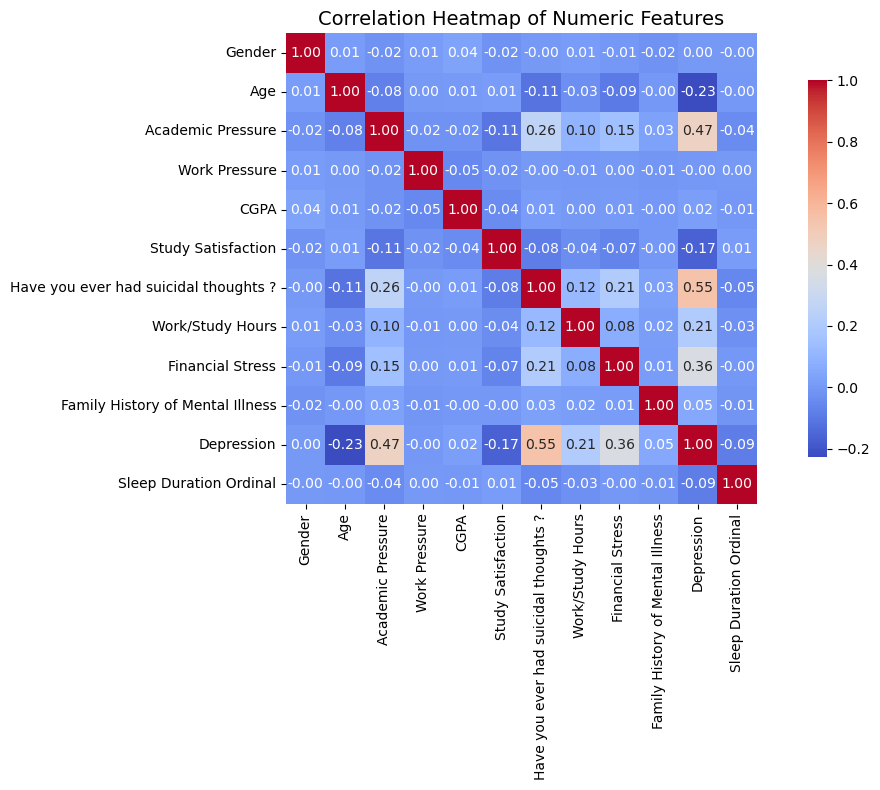

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Computed correlation matrix for numeric columns
corr_matrix = df_cleaned.select_dtypes(include='number').corr()

# Plotted heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': 0.8})
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.tight_layout()
plt.show()


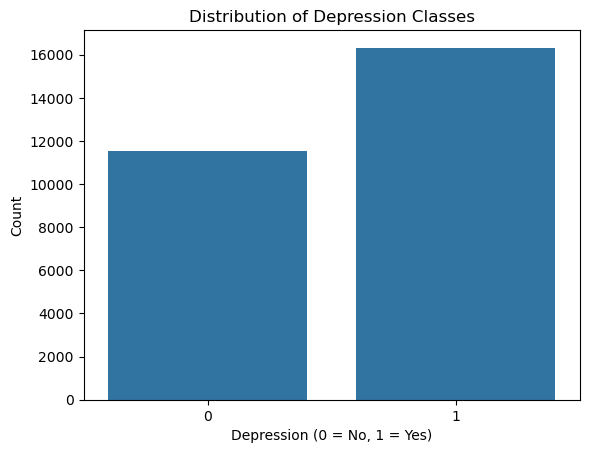

In [8]:
# Distribution of Depression Classes
sns.countplot(x='Depression', data=df_cleaned)
plt.title('Distribution of Depression Classes')
plt.xlabel('Depression (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

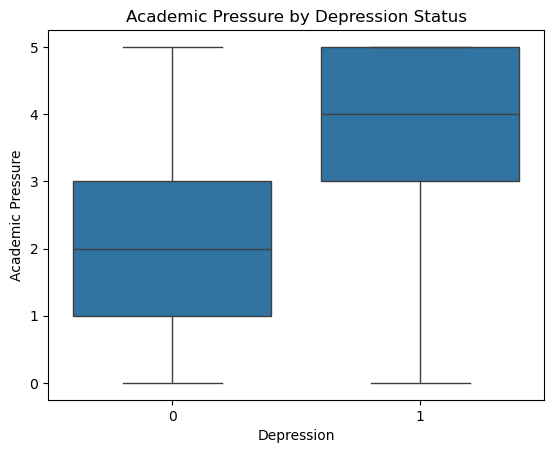

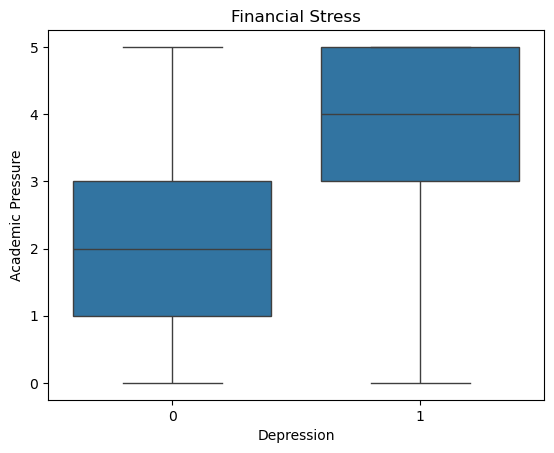

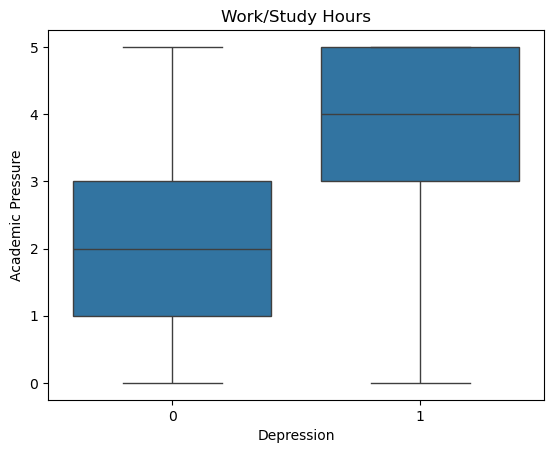

In [9]:
sns.boxplot(x='Depression', y='Academic Pressure', data=df_cleaned)
plt.title('Academic Pressure by Depression Status')
plt.show()
sns.boxplot(x='Depression', y='Academic Pressure', data=df_cleaned)
plt.title('Financial Stress')
plt.show()
sns.boxplot(x='Depression', y='Academic Pressure', data=df_cleaned)
plt.title('Work/Study Hours')
plt.show()

In [10]:
# Checked dtypes to confirm they updated appropriately
df_cleaned.dtypes

Gender                                     int32
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?      int32
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness           int32
Depression                                 int64
Sleep Duration Ordinal                   float64
dtype: object

In [11]:
# Target & Feature selection
target = ['Depression']
selected_features = ['Gender', 'Age', 'Academic Pressure','Have you ever had suicidal thoughts ?', 'Work/Study Hours',
                     'Financial Stress', 'Work Pressure']

In [12]:
from sklearn.model_selection import train_test_split

# Defined features (X) and target (y)
X = df_encoded [selected_features]
y = df_encoded['Depression']

# Aligned with df_cleaned to make sure rows dropped from 'Financial Stress' are also dropped in X and y
X = X.loc[df_cleaned.index]
y = y.loc[df_cleaned.index]

# Split data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Show the shape of the splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22304, 7), (5576, 7), (22304,), (5576,))

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialized the model
logreg = LogisticRegression(
    penalty='l2',
    C=100,
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

# Fit the model
logreg.fit(X_train, y_train)

# Predict on test set
y_pred = logreg.predict(X_test)

# Display results
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8409253945480631
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      2311
           1       0.85      0.88      0.87      3265

    accuracy                           0.84      5576
   macro avg       0.84      0.83      0.83      5576
weighted avg       0.84      0.84      0.84      5576

[[1806  505]
 [ 382 2883]]


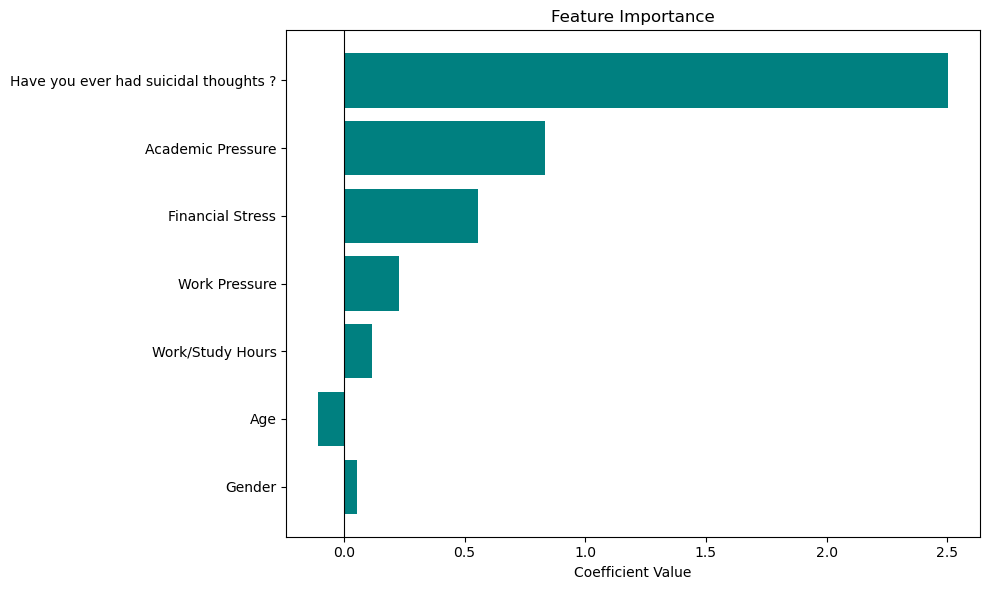

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Created a DataFrame with features and coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg.coef_[0]
})

# Sorted by absolute value of coefficient (most influential at the top)
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=True)

# Horizontal bar chart of Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='teal')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Feature Importance')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV

# Set up hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialized GridSearch with Logistic Regression
logreg_grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
logreg_grid.fit(X_train, y_train)

# Best parameters and best score
best_params = logreg_grid.best_params_
best_score = logreg_grid.best_score_

best_params, best_score

({'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 0.8375628239963089)

In [16]:
# Get predicted probabilities
y_proba = logreg.predict_proba(X_test)

# Show the first 5 predictions
for i in range(5):
    print(f"Sample {i+1}:")
    print(f"  Probability of No Depression (0): {y_proba[i][0]:.2f}")
    print(f"  Probability of Depression (1):   {y_proba[i][1]:.2f}")
    print(f"  Predicted Class: {logreg.predict(X_test.iloc[i:i+1])[0]}")
    print("-" * 40)

Sample 1:
  Probability of No Depression (0): 0.09
  Probability of Depression (1):   0.91
  Predicted Class: 1
----------------------------------------
Sample 2:
  Probability of No Depression (0): 0.08
  Probability of Depression (1):   0.92
  Predicted Class: 1
----------------------------------------
Sample 3:
  Probability of No Depression (0): 0.24
  Probability of Depression (1):   0.76
  Predicted Class: 1
----------------------------------------
Sample 4:
  Probability of No Depression (0): 0.06
  Probability of Depression (1):   0.94
  Predicted Class: 1
----------------------------------------
Sample 5:
  Probability of No Depression (0): 0.03
  Probability of Depression (1):   0.97
  Predicted Class: 1
----------------------------------------


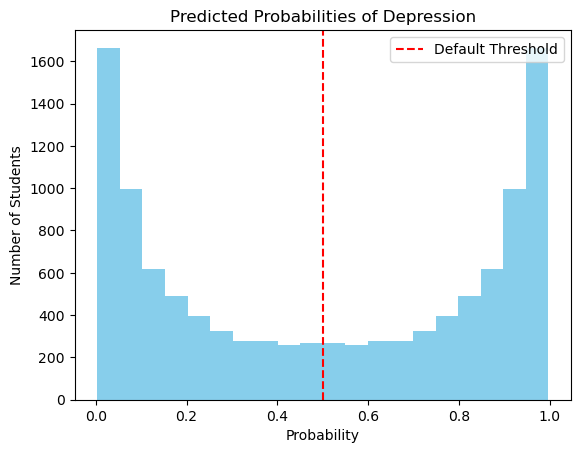

In [17]:
plt.hist(y_proba.ravel(), bins=20, color='skyblue')
plt.axvline(0.5, color='red', linestyle='--', label='Default Threshold')
plt.title('Predicted Probabilities of Depression')
plt.xlabel('Probability')
plt.ylabel('Number of Students')
plt.legend()
plt.show()

In [18]:
# Updated based on best_params
logreg = LogisticRegression(
    penalty='l2',
    C=0.1,  
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

In [19]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [20]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8416427546628408
Confusion Matrix:
 [[1798  513]
 [ 370 2895]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80      2311
           1       0.85      0.89      0.87      3265

    accuracy                           0.84      5576
   macro avg       0.84      0.83      0.84      5576
weighted avg       0.84      0.84      0.84      5576



In [21]:
import joblib

# Saving the model
joblib.dump(logreg, 'student_depression_model.pkl')

joblib.dump(X_train.columns.tolist(), 'model_features.pkl')

['model_features.pkl']